# Implementing a Recommender System with SageMaker, MXNet, and Gluon
_**Making Video Recommendations Using Neural Networks and Embeddings**_

--- 

## Contents

1. [Setup](#Setup)
1. [Data](#Data)
1. [Train Locally](#Train-Locally)
  1. [Define Network](#Define-Network)
  1. [Set Parameters](#Set-Parameters)
  1. [Execute](#Execute)
1. [Train with SageMaker](#Train-with-SageMaker)
  1. [Wrap Code](#Wrap-Code)
  1. [Submit](#Submit)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
1. [Wrap-up](#Wrap-up)

---

## Setup

_This notebook was created and tested on an ml.p2.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the `get_execution_role()` call with the appropriate full IAM role arn string(s).

In [ ]:
import sagemaker
from sagemaker import get_execution_role

#choose the bucket 
bucket = 'sagemaker-test-wc'
prefix = 'gluon'

role = sagemaker.get_execution_role()

Now let's load the Python libraries we'll need for the remainder of this example notebook.

In [1]:
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray
from mxnet.metric import MSE
import pandas as pd
import numpy as np
import sagemaker
from sagemaker.mxnet import MXNet
import boto3
import json
import matplotlib.pyplot as plt

---
## Data

To start, we will conduct explorative data analysis and model developing locally. Once the process can be finalized, we will create a python script and we can use Sagemaker to train and deploy the model. 

### Explore

Let's have a closer look at the data we have. We read the data into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) so that we can begin to understand it.

In [31]:
data_key = 'gluon/train/ratings_sagemaker.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

df = pd.read_csv(data_location)
df.head(5)

,customer_id,product_id,star_rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


timestamp is not needed in this use case so we will drop it first. We will save the total number of customers and products. We will store individual customers and products index for later use

In [37]:
df = df[['customer_id', 'product_id', 'star_rating']]

In [38]:
customers = df['customer_id'].value_counts()
products = df['product_id'].value_counts()

### Clean


In [40]:
customer_index = pd.DataFrame({'customer_id': customers.index, 'user': np.arange(customers.shape[0])})
product_index = pd.DataFrame({'product_id': products.index, 
                              'item': np.arange(products.shape[0])})

df = df.merge(customer_index).merge(product_index)
df.head()

,customer_id,product_id,star_rating,user,item
0,1,1193,5,4131,43
1,2,1193,5,2377,43
2,12,1193,4,5708,43
3,15,1193,4,1576,43
4,17,1193,5,1483,43


### Prepare

Let's start by splitting in training and test sets.  This will allow us to estimate the model's accuracy on videos our customers rated, but wasn't included in our training.

In [41]:
test_df = df.groupby('customer_id').last().reset_index()

train_df = df.merge(test_df[['customer_id', 'product_id']], 
                            on=['customer_id', 'product_id'], 
                            how='outer', 
                            indicator=True)
train_df = df[(train_df['_merge'] == 'left_only')]

Now, we can convert our Pandas DataFrames into MXNet NDArrays, use those to create a member of the SparseMatrixDataset class, and add that to an MXNet Data Iterator.  This process is the same for both test and control.

In [42]:
batch_size = 1024

train = gluon.data.ArrayDataset(nd.array(train_df['user'].values, dtype=np.float32),
                                nd.array(train_df['item'].values, dtype=np.float32),
                                nd.array(train_df['star_rating'].values, dtype=np.float32))
test  = gluon.data.ArrayDataset(nd.array(test_df['user'].values, dtype=np.float32),
                                nd.array(test_df['item'].values, dtype=np.float32),
                                nd.array(test_df['star_rating'].values, dtype=np.float32))

train_iter = gluon.data.DataLoader(train, shuffle=True, num_workers=4, batch_size=batch_size, last_batch='rollover')
test_iter = gluon.data.DataLoader(train, shuffle=True, num_workers=4, batch_size=batch_size, last_batch='rollover')

---

## Train Locally

### Define Network

Defining the neural network version of our matrix factorization task.  In this case, our network is quite simple.  The main components are:
- [Embeddings](https://mxnet.incubator.apache.org/api/python/gluon/nn.html#mxnet.gluon.nn.Embedding) which turn our indexes into dense vectors of fixed size.  In this case, 64.
- [Dense layers](https://mxnet.incubator.apache.org/api/python/gluon.html#mxnet.gluon.nn.Dense) with ReLU activation.  Each dense layer has the same number of units as our number of embeddings.  Our ReLU activation here also adds some non-linearity to our matrix factorization.
- [Dropout layers](https://mxnet.incubator.apache.org/api/python/gluon.html#mxnet.gluon.nn.Dropout) which can be used to prevent over-fitting.
- Matrix multiplication of our user matrix and our item matrix to create an estimate of our rating matrix.

In [43]:
class MFBlock(gluon.HybridBlock):
    def __init__(self, max_users, max_items, num_emb, dropout_p=0.5):
        super(MFBlock, self).__init__()
        
        self.max_users = max_users
        self.max_items = max_items
        self.dropout_p = dropout_p
        self.num_emb = num_emb
        
        with self.name_scope():
            self.user_embeddings = gluon.nn.Embedding(max_users, num_emb)
            self.item_embeddings = gluon.nn.Embedding(max_items, num_emb)
            
            self.dropout_user = gluon.nn.Dropout(dropout_p)
            self.dropout_item = gluon.nn.Dropout(dropout_p)

            self.dense_user   = gluon.nn.Dense(num_emb, activation='relu')
            self.dense_item = gluon.nn.Dense(num_emb, activation='relu')
            
    def hybrid_forward(self, F, users, items):
        a = self.user_embeddings(users)
        a = self.dense_user(a)
        
        b = self.item_embeddings(items)
        b = self.dense_item(b)

        predictions = self.dropout_user(a) * self.dropout_item(b)     
        predictions = F.sum(predictions, axis=1)
        return predictions

In [44]:
num_embeddings = 64

net = MFBlock(max_users=customer_index.shape[0], 
              max_items=product_index.shape[0],
              num_emb=num_embeddings,
              dropout_p=0.5)


### Set Parameters

Let's initialize network weights and set our optimization parameters.

In [45]:
# Initialize network parameters
ctx = mx.cpu()
net.collect_params().initialize(mx.init.Xavier(magnitude=60),
                                ctx=ctx,
                                force_reinit=True)
net.hybridize()

# Set optimization parameters
opt = 'sgd'
lr = 0.02
momentum = 0.9
wd = 0.

trainer = gluon.Trainer(net.collect_params(),
                        opt,
                        {'learning_rate': lr,
                         'wd': wd,
                         'momentum': momentum})

### Execute

Let's define a function to carry out the training of our neural network.

In [46]:
def execute(train_iter, test_iter, net, epochs, ctx):
    
    loss_function = gluon.loss.L2Loss()
    for e in range(epochs):
        
        print("epoch: {}".format(e))
        
        for i, (user, item, label) in enumerate(train_iter):
                user = user.as_in_context(ctx)
                item = item.as_in_context(ctx)
                label = label.as_in_context(ctx)
                
                with mx.autograd.record():
                    output = net(user, item)               
                    loss = loss_function(output, label)
                    
                loss.backward()
                trainer.step(batch_size)

        print("EPOCH {}: MSE ON TRAINING and TEST: {}. {}".format(e,
                                                                   eval_net(train_iter, net, ctx, loss_function),
                                                                   eval_net(test_iter, net, ctx, loss_function)))
    print("end of training")
    return net

Let's also define a function which evaluates our network on a given dataset.  This is called by our `execute` function above to provide mean squared error values on our training and test datasets.

In [47]:
def eval_net(data, net, ctx, loss_function):
    acc = MSE()
    for i, (user, item, label) in enumerate(data):
        
            user = user.as_in_context(ctx)
            item = item.as_in_context(ctx)
            label = label.as_in_context(ctx)
            predictions = net(user, item).reshape((batch_size, 1))
            acc.update(preds=[predictions], labels=[label])
   
    return acc.get()[1]

Now, let's train for a few epochs.

In [48]:
%%time

epochs = 5

trained_net = execute(train_iter, test_iter, net, epochs, ctx)

epoch: 0
EPOCH 0: MSE ON TRAINING and TEST: 1.1686307946881844. 1.1685088436628126
epoch: 1
EPOCH 1: MSE ON TRAINING and TEST: 1.0456271363704261. 1.0457401464086113
epoch: 2
EPOCH 2: MSE ON TRAINING and TEST: 1.0016535882723934. 1.0016523211672672
epoch: 3
EPOCH 3: MSE ON TRAINING and TEST: 0.9370349207489761. 0.9369811942353922
epoch: 4
EPOCH 4: MSE ON TRAINING and TEST: 0.9516036584743143. 0.9515252247161158
end of training
CPU times: user 6min 1s, sys: 6.23 s, total: 6min 7s
Wall time: 5min 38s


#### Early Validation

We can see our training error going down, but our validation accuracy bounces around a bit.  Let's check how our model is predicting for an individual user.  We could pick randomly, but for this case, let's try user #6.

In [49]:
product_index['u6_predictions'] = trained_net(nd.array([6] * product_index.shape[0]).as_in_context(ctx), 
                                              nd.array(product_index['item'].values).as_in_context(ctx)).asnumpy()
product_index.sort_values('u6_predictions', ascending=False).head(10)

,item,product_id,u6_predictions
3145,3145,1423,4.259520
3608,3608,3376,4.155461
3674,3674,2214,4.066185
3452,3452,1877,4.058368
3623,3623,658,4.043023
3368,3368,966,3.988562
3612,3612,1165,3.930141
3585,3585,1133,3.921813
24,24,858,3.905917
3546,3546,2258,3.903018


Now let's compare this to the predictions for another user (we'll try user #7).

In [50]:
product_index['u7_predictions'] = trained_net(nd.array([7] * product_index.shape[0]).as_in_context(ctx), 
                                              nd.array(product_index['item'].values).as_in_context(ctx)).asnumpy()
product_index.sort_values('u7_predictions', ascending=False).head(10)

,item,product_id,u6_predictions,u7_predictions
3145,3145,1423,4.259520,4.259902
3368,3368,966,3.988562,4.229335
3509,3509,1510,3.818976,4.207890
3623,3623,658,4.043023,4.204438
3674,3674,2214,4.066185,4.119068
3608,3608,3376,4.155461,4.087551
3663,3663,3280,3.886381,4.068808
3546,3546,2258,3.903018,4.063592
3326,3326,2244,3.741826,4.040039
3462,3462,643,3.672505,4.033234


The predicted ratings are different between the two users, but the same top (and bottom) items for user #6 appear for #7 as well.  Let's look at the correlation across the full set of 38K items to see if this relationship holds.

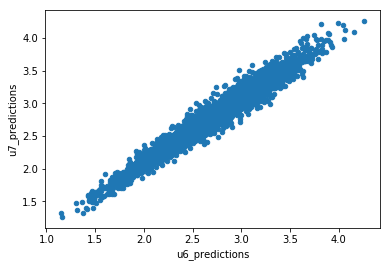

In [51]:
product_index[['u6_predictions', 'u7_predictions']].plot.scatter('u6_predictions', 'u7_predictions')
plt.show()

We can see that this correlation is nearly perfect.  Essentially the average rating of items dominates across users and we'll recommend the same well-reviewed items to everyone.  As it turns out, we can add more embeddings and this relationship will go away since we're better able to capture differential preferences across users.

However, with just a 64 dimensional embedding, it took 7 minutes to run just 3 epochs.  If we ran this outside of our Notebook Instance we could run larger jobs and move on to other work would improve productivity.

---

## Train with SageMaker

Now that we've trained on this smaller dataset, we can expand training in SageMaker's distributed, managed training environment.

### Wrap Code

To use SageMaker's pre-built MXNet container, we'll need to wrap our code from above into a Python script.  There's a great deal of flexibility in using SageMaker's pre-built containers, and detailed documentation can be found [here](https://github.com/aws/sagemaker-python-sdk#mxnet-sagemaker-estimators), but for our example, it consisted of:
1. Wrapping all data preparation into a `prepare_train_data` function (we could name this whatever we like)
1. Copying and pasting classes and functions from above word-for-word
1. Defining a `train` function that:
  1. Adds a bit of new code to pick up the input TSV dataset on the SageMaker Training cluster
  1. Takes in a dict of hyperparameters (which we specified as globals above)
  1. Creates the net and executes training

In [52]:
!cat recommender_test_2.py

import logging
import json
import time
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray
from mxnet.metric import MSE
import numpy as np

os.system('pip install pandas')
import pandas as pd

logging.basicConfig(level=logging.DEBUG)

#########
# Globals
#########

batch_size = 1024


##########
# Training
##########

def train(channel_input_dirs, hyperparameters, hosts, num_gpus, **kwargs):
    
    # get data
    training_dir = channel_input_dirs['train']
    train_iter, test_iter, customer_index, product_index = prepare_train_data(training_dir)
    
    # get hyperparameters
    num_embeddings = hyperparameters.get('num_embeddings', 64)
    opt = hyperparameters.get('opt', 'sgd')
    lr = hyperparameters.get('lr', 0.02)
    momentum = hyperparameters.get('momentum', 0.9)
    wd = hyperparameters.get('wd', 0.)
    epochs = hyperparameters.get('epochs', 5)

    # define net
    ctx = mx.cpu()

    net = MFBlock(max_users=customer_index.shape[0], 
                  max_it

### Submit

Now, we can create an MXNet estimator from the SageMaker Python SDK.  To do so, we need to pass in:
1. Instance type and count for our SageMaker Training cluster.  SageMaker's MXNet containers support distributed GPU training, so we could easily set this to multiple ml.p2 or ml.p3 instances if we wanted.
  - *Note, this would require some changes to our recommender.py script as we would need to setup the context an key value store properly, as well as determining if and how to distribute the training data.*
1. An S3 path for out model artifacts and a role with access to S3 input and output paths.
1. Hyperparameters for our neural network.  Since with a 64 dimensional embedding, our recommendations reverted too closely to the mean, let's increase this by an order of magnitude when we train outside of our local instance.  We'll also increase the epochs to see how our accuracy evolves over time. We'll leave all other hyperparameters the same.

Once we use `.fit()` this creates a SageMaker Training Job that spins up instances, loads the appropriate packages and data, runs our `train` function from `recommender.py`, wraps up and saves model artifacts to S3, and finishes by tearing down the cluster.

In [16]:
# Set optimization parameters
opt = 'sgd'
lr = 0.02
momentum = 0.9
wd = 0.
role = sagemaker.get_execution_role()

In [54]:
m = MXNet('recommender_test_2.py', 
          py_version='py3',
          role=role, 
          train_instance_count=1, 
          train_instance_type="ml.p2.xlarge",
          output_path='s3://{}/{}/output'.format(bucket, prefix),
          hyperparameters={'num_embeddings': 256, 
                           'opt': opt, 
                           'lr': lr, 
                           'momentum': momentum, 
                           'wd': wd,
                           'epochs': 5},
         framework_version='1.1')


m.fit({'train': 's3://{}/{}/train/'.format(bucket, prefix)})

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-823715915892
INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-2018-12-24-20-24-58-412


2018-12-24 20:24:58 Starting - Starting the training job...
2018-12-24 20:25:00 Starting - Launching requested ML instances......
2018-12-24 20:26:03 Starting - Preparing the instances for training.........
2018-12-24 20:27:59 Downloading - Downloading input data
2018-12-24 20:27:59 Training - Downloading the training image...
2018-12-24 20:28:26 Training - Training image download completed. Training in progress..
2018-12-24 20:28:27,172 INFO - root - running container entrypoint
2018-12-24 20:28:27,173 INFO - root - starting train task
2018-12-24 20:28:27,196 INFO - container_support.training - Training starting
2018-12-24 20:28:28,961 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'model_dir': '/opt/ml/model', 'hyperparameters': {'sagemaker_program': 'recommender_test_2.py', 'lr': 0.02, 'sagemaker_container_log_level': 20, 'sagemaker_job_name': 'sagemaker-mxnet-2018-12-24-20-24-58-412', 'num_embeddings': 256, 'momentum': 0.9, 'wd': 0.0, 'opt': 'sgd', 'sagemaker_enable_clou

---

## Host

Now that we've trained our model, deploying it to a real-time, production endpoint is easy.

In [55]:
predictor = m.deploy(initial_instance_count=1, 
                     instance_type='ml.m4.xlarge')
predictor.serializer = None

INFO:sagemaker:Creating model with name: sagemaker-mxnet-2018-12-24-20-24-58-412
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-2018-12-24-20-24-58-412


---------------------------------------------------------------------------!

Now that we have an endpoint, let's test it out.  We'll predict user #6's ratings for the top and bottom ASINs from our local model.

*This could be done by sending HTTP POST requests from a separate web service, but to keep things easy, we'll just use the `.predict()` method from the SageMaker Python SDK.*

In [56]:
predictor.predict(json.dumps({'customer_id': customer_index[customer_index['user'] == 6]['customer_id'].values.tolist(), 
                              'product_id': [3613, 3548]}))

[2.5952696800231934, 2.6618661880493164]

In [59]:
predictor.predict(json.dumps({'customer_id': customer_index[customer_index['user'] == 6]['customer_id'].values.tolist(),
                             'product_id':list(range(0,10))}))

[3.776355266571045,
 3.149517059326172,
 3.0222246646881104,
 2.7463955879211426,
 1.8261686563491821,
 2.427008867263794,
 3.020322322845459,
 2.951674699783325,
 2.7362723350524902,
 2.1687281131744385]

*Note, some of our predictions are actually greater than 5, which is to be expected as we didn't do anything special to account for ratings being capped at that value.  Since we are only looking to ranking by predicted rating, this won't create problems for our specific use case.*

### Evaluate

Let's start by calculating a naive baseline to approximate how well our model is doing.  The simplest estimate would be to assume every user item rating is just the average rating over all ratings.

*Note, we could do better by using each individual video's average, however, in this case it doesn't really matter as the same conclusions would hold.*

In [60]:
print('Naive MSE:', np.mean((test_df['star_rating'] - np.mean(train_df['star_rating'])) ** 2))

Naive MSE: 1.6737109919841058


Now, we'll calculate predictions for our test dataset.

*Note, this will align closely to our CloudWatch output above, but may differ slightly due to skipping partial mini-batches in our eval_net function.*

In [61]:
test_preds = []
for array in np.array_split(test_df[['customer_id', 'product_id']].values, 40):
    test_preds += predictor.predict(json.dumps({'customer_id': array[:, 0].tolist(), 
                                                'product_id': array[:, 1].tolist()}))

test_preds = np.array(test_preds)
print('MSE:', np.mean((test_df['star_rating'] - test_preds) ** 2))

MSE: 1.2785772457718834


We can see that our neural network and embedding model produces substantially better results (~1.27 vs 1.67 on mean square error).

For recommender systems, subjective accuracy also matters.  Let's get some recommendations for a random user to see if they make intuitive sense.

In [63]:
df[df['user'] == 6].sort_values(['star_rating', 'item'], ascending=[False, True]).head(5)

,customer_id,product_id,star_rating,user,item
136535,3618,593,5,6,9
190544,3618,858,5,6,24
219754,3618,50,5,6,38
600199,3618,1304,5,6,80
340827,3618,1358,5,6,135


Now we'll loop through and predict user #6's ratings for every common video in the catalog, to see which ones we'd recommend and which ones we wouldn't.

In [65]:
predictions = []
for array in np.array_split(product_index['product_id'].values, 40):
    predictions += predictor.predict(json.dumps({'customer_id': customer_index[customer_index['user'] == 6]['customer_id'].values.tolist() * array.shape[0], 
                                                 'product_id': array.tolist()}))

predictions = pd.DataFrame({'product_id': product_index['product_id'],
                            'prediction': predictions})

*Note, because of random initialization in the weights, results on subsequent runs may differ slightly.*

Let's confirm that we no longer have almost perfect correlation in recommendations with user #7.

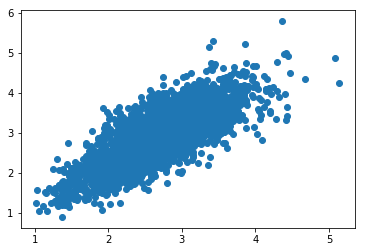

In [66]:
predictions_user7 = []
for array in np.array_split(product_index['product_id'].values, 40):
    predictions_user7 += predictor.predict(json.dumps({'customer_id': customer_index[customer_index['user'] == 7]['customer_id'].values.tolist() * array.shape[0], 
                                                       'product_id': array.tolist()}))
plt.scatter(predictions['prediction'], np.array(predictions_user7))
plt.show()

---

## Wrap-up

In this example, we developed a deep learning model to predict customer ratings.  This could serve as the foundation of a recommender system in a variety of use cases.  However, there are many ways in which it could be improved.  For example we did very little with:
- hyperparameter tuning
- controlling for overfitting (early stopping, dropout, etc.)
- testing whether binarizing our target variable would improve results
- including other information sources (video genres, historical ratings, time of review)
- adjusting our threshold for user and item inclusion 

In addition to improving the model, we could improve the engineering by:
- Setting the context and key value store up for distributed training
- Fine tuning our data ingestion (e.g. num_workers on our data iterators) to ensure we're fully utilizing our GPU
- Thinking about how pre-processing would need to change as datasets scale beyond a single machine

Beyond that, recommenders are a very active area of research and techniques from active learning, reinforcement learning, segmentation, ensembling, and more should be investigated to deliver well-rounded recommendations.

### Clean-up (optional)

Let's finish by deleting our endpoint to avoid stray hosting charges.

In [67]:
sagemaker.Session().delete_endpoint(predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: sagemaker-mxnet-2018-12-24-20-24-58-412
